In [1]:
import numpy as np, pandas as pd
import json
import ast 
from textblob import TextBlob
import nltk
import torch
import pickle
from scipy import spatial
import warnings
warnings.filterwarnings('ignore')
import spacy
from nltk import Tree
en_nlp = spacy.load('en')
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
train = pd.read_csv("data/train_with_answers.csv")

In [3]:
train.shape

(130319, 5)

### Loading Embedding dictionary

In [4]:
with open("data/dict_embeddings1.pickle", "rb") as f:
    d1 = pickle.load(f)

In [5]:
with open("data/dict_embeddings2.pickle", "rb") as f:
    d2 = pickle.load(f)

In [6]:
dict_emb = dict(d1)
dict_emb.update(d2)

In [7]:
len(dict_emb)

223345

In [8]:
#print(dict_emb[item][0])
#lambda x: x+3
#train['sentences'] = train['context'].apply(lambda x: [item.raw for item in TextBlob(x).sentences])
#train['sentences'].apply(lambda x: [print(len(dict_emb[item][0])) if item in dict_emb else np.zeros(4096) for item in x])

In [9]:
del d1, d2

## Data Processing

In [10]:
def get_target(x):
    idx = -1
    for i in range(len(x["sentences"])):
        if (x["answers"]== "no"): idx = -1
        elif x["text"] in x["sentences"][i]: idx = i
        # else idx = -1
    return idx

In [11]:
train.head(5)

,answer_start,answers,context,question,text
0,269,yes,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s
1,207,yes,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing
2,526,yes,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003
3,166,yes,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas"
4,276,yes,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s


In [12]:
train.memory_usage (index = True, deep = True)

Index                  80
answer_start      1042552
answers           7775642
context         130824648
question         15084292
text             10207009
dtype: int64

In [13]:
train.shape

(130319, 5)

In [14]:
train.dropna(inplace=True)

In [15]:
train.shape

(130318, 5)

In [16]:
def process_data(train):
    
    print("step 1")
    train['sentences'] = train['context'].apply(lambda x: [item.raw for item in TextBlob(x).sentences])
    
    print("step 2")
    train["target"] = train.apply(get_target, axis = 1)
    
    print("step 3")
    train['sent_emb'] = train['sentences'].apply(
        lambda x: [dict_emb[item][0] if item in dict_emb 
                    else np.zeros(4096) for item in x])
                   #else print("item:\n",item) for item in x])

    #train['quest_emb'] =[]
    #for i in range(0,len(train.shape[0]-200,200)):
    #    print(i)
    #    train['sent_emb'] = train['sentences'].iloc[i,i+200].apply(lambda x: [dict_emb[item][0] if item in\
    #                                                       dict_emb else np.zeros(4096) for item in x])

    print("step 4")
    train['quest_emb'] = train['question'].apply(lambda x: dict_emb[x] if x in dict_emb else np.zeros(4096))
        
    return train

### You wonder how we get the target ? Let's try to get the target of the question asking when Beyoncé rose to fame

In [159]:
# print(dict_emb)

def get_one_target(x):
    idx = -1
    print("sentences where it has to find the target :\n",x["sentences"])
    for i in range(len(x["sentences"])):
        if (x["answers"]== "no"):
            print("pas de réponse")
        elif x["text"] in x["sentences"][i]: 
            print("target :\n",x["sentences"][i])
            return i

In [163]:
train.iloc[0]


answer_start                                                  269
answers                                                       yes
context         Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
question                 When did Beyonce start becoming popular?
text                                            in the late 1990s
sentences       [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...
target                                                          1
sent_emb        [[0.030376578, 0.044331014, 0.081356354, 0.062...
quest_emb       [[0.01491953, 0.021973763, 0.021364095, 0.0393...
Name: 0, dtype: object

In [164]:
get_one_target(train.iloc[0])

sentences where it has to find the target :
 ['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress.', "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.", "Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time.", 'Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".']
target :
 Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.


1

### Now let's create the train dataframe that will gives us the vectorized sentences and questions

In [165]:
train = process_data(train)

step 1


KeyboardInterrupt: 

In [166]:
#print(train.head(3))
train[["sent_emb","quest_emb"]].head(3)

,sent_emb,quest_emb
0,"[[0.030376578, 0.044331014, 0.081356354, 0.062...","[[0.01491953, 0.021973763, 0.021364095, 0.0393..."
1,"[[0.030376578, 0.044331014, 0.081356354, 0.062...","[[0.04444952, 0.028005758, 0.030357722, 0.0375..."
2,"[[0.030376578, 0.044331014, 0.081356354, 0.062...","[[0.03949683, 0.04509903, 0.018089347, 0.07667..."



## Predicted Cosine & Euclidean Index

In [21]:
def cosine_sim(x):
    li = []
    '''
    for item in x["sent_emb"]:
        li.append(spatial.distance.cosine(item,x["quest_emb"][0]))
    return li
    '''
    import time
    t0 = time.time()
    i = 0
    for item in x["sent_emb"]:
        i += 1
        if i ==0:
            print(item)
        if i%1000 == 0:
            t1 = time.time()
            total = t1-t0
            print("cosine_sim of item ",i," time since beginning:", total)
        sent_emb = item if item is not None else 0
        quest_emb = x["quest_emb"][0] if x["quest_emb"][0] is not None else 0
        li.append(spatial.distance.cosine(sent_emb, quest_emb))
    return li

In [22]:
def pred_idx(distances):
    # result = np.argmin(distances) if np.argmin(distances) <0.5 else 0
    return np.argmin(distances)

In [23]:
def get_result_cos(x):
    if x["pred_idx_cos"] == x["target"]:
        return True
    else:
        return False

In [24]:
def get_answers(x):
    if x["answers"] == "yes":
        return True
    else:
        return False

In [25]:
def predictions(train):

    print("cosine_sim")
    train["cosine_sim"] = train.apply(cosine_sim, axis = 1)
    print("diff")
    train["diff"] = (train["quest_emb"] - train["sent_emb"])**2
    print("euclidean_dis")
    train["euclidean_dis"] = train["diff"].apply(lambda x: list(np.sum(x, axis = 1)))
    del train["diff"]
    
    print("prediction start")
    
    train["pred_idx_cos"] = train["cosine_sim"].apply(lambda x: pred_idx(x))
    train["pred_idx_euc"] = train["euclidean_dis"].apply(lambda x: pred_idx(x))
    
    # test stats
    print("collecting results")
    stats = pd.DataFrame(index=train.index)
    stats["cos_exists_answer"] = train.apply(get_answers, axis = 1) 
    stats["cos_result"] = train["cosine_sim"].apply(lambda x: np.min(x))
    stats["euc_exists_answer"] = train.apply(get_answers, axis = 1) 
    stats["euc_result"] = train["euclidean_dis"].apply(lambda x: np.min(x))
    
    return train, stats



In [26]:
train_new1, train_new2, train_new3,train_new4, train_new5, train_new6,train_new7, train_new8, train_new9 = np.array_split(train, 9)


In [27]:

'''import theano.tensor as T
from theano import function
x = T.dmatrix('x')
y = T.dmatrix('y')
z = x - y
f = function([x, y], z)   
print(f(train_new1["quest_emb"],train_new1["sent_emb"]))'''

'import theano.tensor as T\nfrom theano import function\nx = T.dmatrix(\'x\')\ny = T.dmatrix(\'y\')\nz = x - y\nf = function([x, y], z)   \nprint(f(train_new1["quest_emb"],train_new1["sent_emb"]))'

In [28]:
predicted, stats = predictions(train_new1)

cosine_sim
diff
euclidean_dis
prediction start
collecting results


In [103]:
predicted.head(3)

,answer_start,answers,context,question,text,sentences,target,sent_emb,quest_emb,cosine_sim,euclidean_dis,pred_idx_cos,pred_idx_euc,root_match_idx
0,269,yes,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/...,1,"[array([0.03037658, 0.04433101, 0.08135635, .....",[[0.01491953 0.02197376 0.02136409 ... 0.01360...,"[0.1401391625404358, 0.11776834726333618, 0.09...","[2.8352642, 2.4563262, 1.5417788, 2.9730926]",2,2,[]
1,207,yes,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/...,1,"[array([0.03037658, 0.04433101, 0.08135635, .....",[[0.04444952 0.02800576 0.03035772 ... 0.02242...,"[0.12254136800765991, 0.08665323257446289, 0.0...","[2.396976, 1.7860672, 1.1152366, 2.3845947]",2,2,[]
2,526,yes,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/...,3,"[array([0.03037658, 0.04433101, 0.08135635, .....",[[0.03949683 0.04509903 0.01808935 ... 0.04610...,"[0.09432470798492432, 0.06841456890106201, 0.0...","[1.8688717, 1.4023948, 1.0954475, 1.7620108]",1,2,[]


In [30]:
# stats = stats.drop(columns=['cos_succ','euc_succ'])
print(stats.shape)
stats.head(3)

(14480, 4)


,cos_exists_answer,cos_result,euc_exists_answer,euc_result
0,True,0.099913,True,1.541779
1,True,0.073723,True,1.115237
2,True,0.068415,True,1.095448


### Plot when prediction was True and when False

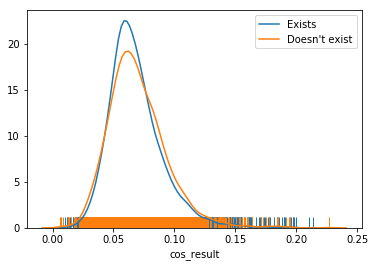

None


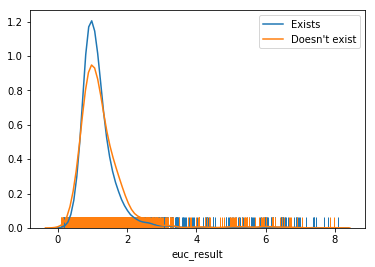

None


In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cosinus similarity
# Create a color if the group is "B"
my_color=np.where(stats['cos_exists_answer'] == False, 'orange', 'skyblue')

# Sort the dataframe by target
target_0 = stats.loc[stats['cos_exists_answer'] == True]
target_1 = stats.loc[stats['cos_exists_answer'] == False]
sns.distplot(target_0['cos_result'].dropna(), hist=False, rug=True, label= 'Exists')
sns.distplot(target_1['cos_result'].dropna(), hist=False, rug=True, label= 'Doesn\'t exist')
print(plt.show())

# euclidian similarity
my_color=np.where(stats['euc_exists_answer'] == False, 'orange', 'skyblue')

target_0 = stats.loc[stats['euc_exists_answer'] == True]
target_1 = stats.loc[stats['euc_exists_answer'] == False]
sns.distplot(target_0['euc_result'].dropna(), hist=False, rug=True, label= 'Exists')
sns.distplot(target_1['euc_result'].dropna(), hist=False, rug=True, label= 'Doesn\'t exist')
print(plt.show())

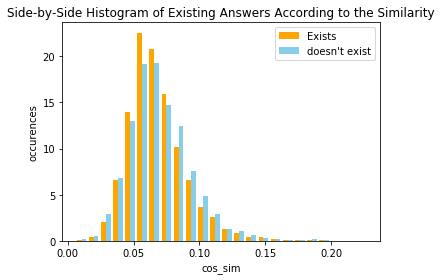

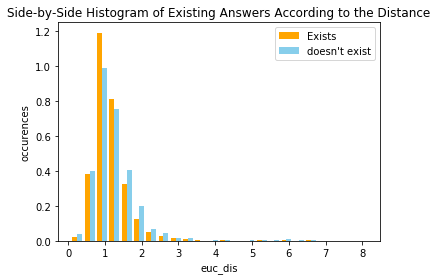

In [48]:
## Cos similarity
# Make a separate list for each airline
target_0 = stats.loc[stats['cos_exists_answer'] == True]
target_1 = stats.loc[stats['cos_exists_answer'] == False]
x0 = list(target_0['cos_result'].dropna())
x1 = list(target_1['cos_result'].dropna())


# Assign colors for each airline and the names
colors = ['orange', 'skyblue']
names = ['Exists','doesn\'t exist']

# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x0, x1], bins = int(360/15), normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('cos_sim')
plt.ylabel('occurences')
plt.title('Side-by-Side Histogram of Existing Answers According to the Similarity')

plt.tight_layout()
plt.show()

## Euc distance
# Make a separate list for each airline
target_0 = stats.loc[stats['euc_exists_answer'] == True]
target_1 = stats.loc[stats['euc_exists_answer'] == False]
x0 = list(target_0['euc_result'].dropna())
x1 = list(target_1['euc_result'].dropna())


# Assign colors for each airline and the names
colors = ['orange', 'skyblue']
names = ['Exists','doesn\'t exist']

# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x0, x1], bins = int(360/15), normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('euc_dis')
plt.ylabel('occurences')
plt.title('Side-by-Side Histogram of Existing Answers According to the Distance')

plt.tight_layout()
plt.show()

### Plot binary classification

I should do that ...

In [148]:
predicted["cosine_sim"][0]

'[0.1401391625404358, 0.11776834726333618, 0.09991294145584106, 0.12237358093261719]'

In [149]:
predicted["euclidean_dis"][0]


'[2.8352642, 2.4563262, 1.5417788, 2.9730926]'

## Accuracy

In [150]:
def accuracy(target, predicted):
    
    acc = (target==predicted).sum()/len(target)
    
    return acc

### Accuracy for euclidean Distance¶

In [151]:
print(accuracy(predicted["target"], predicted["pred_idx_euc"]))


0.32064917127071824


### Accuracy for Cosine Similarity

In [152]:
print(accuracy(predicted["target"], predicted["pred_idx_cos"]))

0.42513812154696135


In [153]:
predicted.to_csv("train_detect_sent.csv", index=None)

In [57]:
predicted.iloc[10000,:]

answer_start                                                    28
answers                                                        yes
context          Track lighting, invented by Lightolier, was po...
question                              Who invented track lighting?
text                                                    Lightolier
sentences        [Track lighting, invented by Lightolier, was p...
target                                                           0
sent_emb         [[0.03775628, 0.06320542, 0.028519485, 0.05910...
quest_emb        [[0.02497383, -0.0061389413, 0.028684806, 0.03...
cosine_sim       [0.12625586986541748, 0.14292508363723755, 0.1...
euclidean_dis    [2.5882096, 2.765382, 2.3747408, 1.599216, 2.2...
pred_idx_cos                                                     0
pred_idx_euc                                                     3
Name: 10000, dtype: object

In [58]:
ct,k = 0,0
for i in range(predicted.shape[0]):
    if predicted.iloc[i,12] != predicted.iloc[i,6]:
        k += 1
    if predicted.iloc[i,12] == predicted.iloc[i,6]:
        ct += 1

In [59]:
ct, k


(4643, 9837)

### Combining Accuracy

In [60]:
label = []
for i in range(predicted.shape[0]):
    if predicted.iloc[i,11] == predicted.iloc[i,12]:
        label.append(predicted.iloc[i,11])
    else:
        label.append((predicted.iloc[i,11],predicted.iloc[i,12]))

In [61]:
ct  ==  0
for  i  in range(predicted.shape[0]):
    item =  predicted["target"][i]
try:
    if label[i] == predicted["target"][i]: ct +=1
except:
    if item in label[i]: ct +=1

In [62]:
ct/predicted.shape[0]


0.3207182320441989

# Root Match

In [63]:
predicted = pd.read_csv("train_detect_sent.csv").reset_index(drop=True)

In [64]:
doc = en_nlp(predicted.iloc[0,2])

In [67]:
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

In [68]:
[to_nltk_tree(sent.root).pretty_print()  for sent in en_nlp(predicted.iloc[0,2]).sents]

                                                          is                                                                                  
  ________________________________________________________|____________________________________________                                        
 |                               Carter                                                              singer                                   
 |      ___________________________|_____________________________________             _________________|_______________                        
 |     |     |   |   |   |   |     |                 say                born         |     |      |                songwriter                 
 |     |     |   |   |   |   |     |          ________|_______           |           |     |      |     _______________|_________              
 |     |     |   |   |   |   |  Giselle      |        |   |  YON     September       |     |      |    |                      producer     

[None, None, None, None]

In [69]:
for sent in doc.sents:
    roots = [st.stem(chunk.root.head.text.lower()) for chunk in sent.noun_chunks]
    print(roots)

['is', 'is', 'sing', 'songwrit', 'produc']
['in', 'houston', 'perform', 'in', 'as', 'to', 'in', 'as', 'of']
['by', 'fath', 'becam', 'of', 'of']
['saw', 'saw', 'of', 'in', 'est', 'as', 'earn', 'feat', 'singl', 'in', 'crazy']


In [96]:
def match_roots(x):
    question = x["question"].lower()
    sentences = en_nlp(x["context"].lower()).sents
    
    question_root = st.stem(str([sent.root for sent in en_nlp(question).sents][0]))
    li = []
    for i,sent in enumerate(sentences):
        roots = [st.stem(chunk.root.head.text.lower()) for chunk in sent.noun_chunks]

        if question_root in roots: 
            for k,item in enumerate(ast.literal_eval(x["sentences"])):
                if str(sent) in item.lower(): 
                    li.append(k)
    return li

In [115]:
predicted["question"][0]


'When did Beyonce start becoming popular?'

In [116]:
predicted["context"][0]


'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

In [102]:
print(len(predicted))
from tqdm import tqdm
tqdm.pandas()
predicted["root_match_idx"] = predicted.progress_apply(match_roots, axis = 1)

  0%|          | 0/14480 [00:00<?, ?it/s]

14480


100%|██████████| 14480/14480 [18:56<00:00, 14.86it/s]


In [112]:
predicted["root_match_idx_first"]= predicted["root_match_idx"].apply(lambda x: x[0] if len(x)>0 else -1)

In [113]:
predicted.head()

,answer_start,answers,context,question,text,sentences,target,sent_emb,quest_emb,cosine_sim,euclidean_dis,pred_idx_cos,pred_idx_euc,root_match_idx,root_match_idx_first
0,269,yes,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/...,1,"[array([0.03037658, 0.04433101, 0.08135635, .....",[[0.01491953 0.02197376 0.02136409 ... 0.01360...,"[0.1401391625404358, 0.11776834726333618, 0.09...","[2.8352642, 2.4563262, 1.5417788, 2.9730926]",2,2,[],-1
1,207,yes,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/...,1,"[array([0.03037658, 0.04433101, 0.08135635, .....",[[0.04444952 0.02800576 0.03035772 ... 0.02242...,"[0.12254136800765991, 0.08665323257446289, 0.0...","[2.396976, 1.7860672, 1.1152366, 2.3845947]",2,2,[],-1
2,526,yes,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/...,3,"[array([0.03037658, 0.04433101, 0.08135635, .....",[[0.03949683 0.04509903 0.01808935 ... 0.04610...,"[0.09432470798492432, 0.06841456890106201, 0.0...","[1.8688717, 1.4023948, 1.0954475, 1.7620108]",1,2,[],-1
3,166,yes,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/...,1,"[array([0.03037658, 0.04433101, 0.08135635, .....",[[0.03284301 0.01849968 0.02034627 ... 0.02206...,"[0.1274968981742859, 0.09279131889343262, 0.08...","[2.4843664, 1.894182, 1.2221413, 2.5239604]",2,2,[],-1
4,276,yes,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/...,1,"[array([0.03037658, 0.04433101, 0.08135635, .....",[[0.03003643 0.01056742 0.01999657 ... 0.01232...,"[0.12346065044403076, 0.10314065217971802, 0.0...","[2.5265627, 2.172618, 1.3479614, 2.6632156]",2,2,[],-1


### I wonder why we got such bad results at finding common roots ?

In [174]:
def match_once_roots(x):
    question = x["question"].lower()
    sentences = en_nlp(x["context"].lower()).sents
    print("question :\n",question)
    print("sentences :\n",sentences)
    question_root = st.stem(str([sent.root for sent in en_nlp(question).sents][0]))
    li = []
    print("question_root :",question_root)
    for i,sent in enumerate(sentences):
        roots = [st.stem(chunk.root.head.text.lower()) for chunk in sent.noun_chunks]
        print("roots :",roots)

        if question_root in roots: 
            for k,item in enumerate(ast.literal_eval(x["sentences"])):
                if str(sent) in item.lower(): 
                    li.append(k)
    return li

In [175]:
match_once_roots(predicted.iloc[1])

question :
 what areas did beyonce compete in when she was growing up?
sentences :
question_root : compet
roots : ['is', 'is', 'sing', 'songwrit', 'produc']
roots : ['in', 'perform', 'in', 'as', 'to', 'in', 'as', 'of']
roots : ['by', 'man', 'becam', 'of', 'of']
roots : ['saw', 'saw', 'of', 'in', 'est', 'as', 'earn', 'feat', 'in', 'singl']


[]

Seems, just underperforming on this extract of this new dataset :)

### Let's try to know how much it performs

In [176]:
(predicted["root_match_idx_first"]==predicted["target"]).sum()/predicted.shape[0]

0.29191988950276243

In [177]:
predicted.to_csv("train_detect_sent.csv", index=None)
